In [1]:
# --- GPU 고정 (세션 처음 1회) ---
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # A100이 단일 장치라면 0으로 충분

# (선택) 간단한 확인
try:
    import torch
    print("Torch CUDA:", torch.cuda.is_available(), torch.cuda.device_count())
    if torch.cuda.is_available():
        print("GPU Name:", torch.cuda.get_device_name(0))
except Exception as e:
    print("Torch check skipped:", e)

# nvidia-smi 간단 출력 (Colab이 아니면 무시 가능)
!nvidia-smi || true

Torch CUDA: True 1
GPU Name: NVIDIA A10
Sun Sep  7 04:06:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     On  |   00000000:17:00.0 Off |                    0 |
|  0%   42C    P0             57W /  150W |    5484MiB /  23028MiB |      3%      Default |
|                                         |                        |                  N/A |
+-------

In [2]:
#그래프차트에 한국어 표시 가능
!pip install koreanize-matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [4]:
# 필수 임포트 (한 번만 실행)
from lightgbm import LGBMRegressor

In [5]:
!pip install --upgrade pip setuptools wheel
!pip install \
  numpy==2.0.2 \
  pandas==2.2.2 \
  scikit-learn==1.6.1 \
  xgboost==3.0.4 \
  lightgbm==4.6.0 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install catboost -q

In [7]:
import pandas as pd

# 가장 단순한 방법 (상대경로)
train_df = pd.read_csv("/home/ubuntu/workspace/data/train/train.csv")
price_df = pd.read_csv("/home/ubuntu/workspace/data/train/price.csv")
room_df  = pd.read_csv("/home/ubuntu/workspace/data/train/room_type.csv")
train_group_df = pd.read_csv("/home/ubuntu/workspace/data/train/meta/TRAIN_group.csv")
TRAIN_hwadam_df = pd.read_csv("/home/ubuntu/workspace/data/train/meta/TRAIN_hwadam.csv")
TRAIN_room_df = pd.read_csv("/home/ubuntu/workspace/data/train/meta/TRAIN_room.csv")
TRAIN_ski_df = pd.read_csv("/home/ubuntu/workspace/data/train/meta/TRAIN_ski.csv")
TRAIN_weather_df = pd.read_csv("/home/ubuntu/workspace/data/train/meta/TRAIN_weather.csv")

In [8]:
import glob
test_df = sorted(glob.glob("/home/ubuntu/workspace/data/train/test/TEST_*.csv"))

df_test_list = []
for file in test_df:
    tmp = pd.read_csv(file)
    tmp['test_file'] = file.split('/')[-1].replace('.csv','')  # TEST_00, TEST_01 ...
    df_test_list.append(tmp)

test_df = pd.concat(df_test_list, ignore_index=True)

In [9]:
# sample_path = "/home/ubuntu/workspace/data/sample_submission.csv"

# # --- 제출 저장 경로 ---
# SUBMIT_DIR = Path("/home/ubuntu/workspace/data/submission")
# SUBMIT_DIR.mkdir(parents=True, exist_ok=True)
# SUBMIT_PATH = SUBMIT_DIR / "submission_xgb_gpu_2.csv"

# len(train_df), len(test_df), sample_path, str(SUBMIT_PATH)

NameError: name 'Path' is not defined

In [9]:
import pandas as pd
import numpy as np

def preprocess_external_daily(
    train_df,
    price_df=None,                 # optional
    TRAIN_hwadam_df=None,          # 화담숲/화담채/모노레일/리프트(일자)
    TRAIN_ski_df=None,             # 8~16시
    TRAIN_weather_df=None,         # '일시' 컬럼
    fill_missing_dates=True        # 연속 날짜 보장
):
    # 0) 날짜 표준화 -----------------------------------------------------------
    train_df = train_df.copy()
    train_df["영업일자"] = pd.to_datetime(train_df["영업일자"])

    daily_keys = pd.DataFrame({"영업일자": sorted(train_df["영업일자"].unique())})
    if fill_missing_dates:
        # train 구간의 전체 날짜 시퀀스 확보(결측일 0/NaN 채우기용)
        full_range = pd.date_range(train_df["영업일자"].min(), train_df["영업일자"].max(), freq="D")
        daily_keys = pd.DataFrame({"영업일자": full_range})

    # 1) 관광/방문객 -----------------------------------------------------------
    ext = daily_keys.copy()

    if TRAIN_hwadam_df is not None:
        v = TRAIN_hwadam_df.copy()
        v["영업일자"] = pd.to_datetime(v["영업일자"])
        # 운영 외 구간은 0으로(후에 시즌 플래그도 추가)
        for col in [c for c in v.columns if c != "영업일자"]:
            v[col] = v[col].fillna(0)
        ext = ext.merge(v, on="영업일자", how="left")

    # 2) 스키(시간대→일자 요약) ------------------------------------------------
    if TRAIN_ski_df is not None:
        s = TRAIN_ski_df.copy()
        s["영업일자"] = pd.to_datetime(s["영업일자"])
        ski_cols = [c for c in s.columns if c.endswith("시")]
        s["ski_total"] = s[ski_cols].sum(axis=1)
        s["ski_peak"] = s[ski_cols].max(axis=1)
        # 피크 시간대가 전부 0인 날은 임의 8로 통일(정보 없음 방지)
        s["ski_peak_hour"] = s[ski_cols].idxmax(axis=1).str.replace("시","", regex=False)
        s["ski_peak_hour"] = pd.to_numeric(s["ski_peak_hour"], errors="coerce").fillna(8).astype(int)
        s = s[["영업일자","ski_total","ski_peak","ski_peak_hour"]]
        ext = ext.merge(s, on="영업일자", how="left")

    # 3) 날씨('일시' → 하루 집계) ----------------------------------------------
    if TRAIN_weather_df is not None:
        w = TRAIN_weather_df.copy()

        # '일시' → datetime → 날짜로 집계 키 생성
        w["일시"] = pd.to_datetime(w["일시"])
        w["영업일자"] = w["일시"].dt.floor("D")
    
        # 3-1) 시간 문자열(예: '13:55')을 분(min)으로 변환
        time_cols = [c for c in w.columns if "시각" in c]
        for c in time_cols:
            # 'HH:MM' → 분 단위 정수, 변환 실패는 NaN
            w[c] = pd.to_datetime(w[c], format="%H:%M", errors="coerce")
            w[c] = w[c].dt.hour * 60 + w[c].dt.minute
    
        # 3-2) 숫자로 바꿀 수 있는 건 전부 숫자로 (섭씨·강수량 등)
        for c in w.columns:
            if c in ["일시","영업일자"]:
                continue
            w[c] = pd.to_numeric(w[c], errors="coerce")
    
        # 3-3) 집계 규칙 정의
        agg_map = {}
        for c in w.columns:
            if c in ["일시","영업일자"]:
                continue
            if "강수" in c:
                agg_map[c] = "sum"      # 강수량은 일합계
            elif ("기온" in c) or (c in time_cols):
                agg_map[c] = "mean"     # 온도/시각은 평균(분 단위)
            else:
                agg_map[c] = "mean"     # 기타 수치도 평균
    
        w_day = w.groupby("영업일자", as_index=False).agg(agg_map)
    
        # 3-4) 파생: 일교차/비 여부
        cand_max = [c for c in w_day.columns if "최고기온" in c]
        cand_min = [c for c in w_day.columns if "최저기온" in c]
        if cand_max and cand_min:
            w_day["temp_diff"] = w_day[cand_max[0]] - w_day[cand_min[0]]
    
        rain_cols = [c for c in w_day.columns if "강수량" in c]
        if rain_cols:
            w_day["is_rainy"] = (w_day[rain_cols[0]] > 0).astype(int)
    
        # (선택) 시각 열을 다시 'HH:MM' 문자열로 복원하고 싶다면:
        for c in time_cols:
            if c in w_day.columns:
                mins = w_day[c].round().astype("Int64")
                hh = (mins // 60).astype("Int64")
                mm = (mins % 60).astype("Int64")
                w_day[c] = (hh.astype(str).str.zfill(2) + ":" + mm.astype(str).str.zfill(2))
    
        ext = ext.merge(w_day, on="영업일자", how="left")


    # 4) 시즌 플래그 ------------------------------------------------------------
    ext["month"] = ext["영업일자"].dt.month
    # (운영 달은 필요에 따라 수정)
    ext["is_ski_season"]    = ext["month"].isin([1,2,12]).astype(int)
    ext["is_hwadam_season"] = ext["month"].between(3,11).astype(int)

    # 5) lag / rolling (일자 단위에서 만든 뒤 나중에 매출 데이터에 머지) -------
    def add_lag_roll(df, cols, lags=(1,), windows=(7,)):
        out = df.copy()
        out = out.sort_values("영업일자")
        for c in cols:
            if c not in out.columns: 
                continue
            for L in lags:
                out[f"{c}_lag{L}"] = out[c].shift(L)
            for W in windows:
                out[f"{c}_{W}dmean"] = out[c].rolling(W, min_periods=1).mean()
        return out

    visitor_cols = [c for c in ext.columns if c in ["화담숲","화담채","모노레일","리프트"]]
    ski_cols_add = ["ski_total","ski_peak"]
    weather_core = []
    weather_core += [c for c in ext.columns if "평균기온" in c]
    weather_core += [c for c in ext.columns if "강수량" in c]

    ext = add_lag_roll(ext, visitor_cols + ski_cols_add + weather_core,
                       lags=(1,7), windows=(7,14))

    # 결측 정리(머지 전)
    num_cols = ext.columns.difference(["영업일자"])
    ext[num_cols] = ext[num_cols].fillna(0)

    # # 6) 가격(선택) ------------------------------------------------------------
    # if price_df is not None and "영업장명_메뉴명" in train_df.columns:
    #     train_df = train_df.merge(price_df[["영업장명_메뉴명","평균판매금액"]],
    #                               on="영업장명_메뉴명", how="left")
    #     train_df["매출액"] = train_df["매출수량"] * train_df["평균판매금액"]

    # 6) 가격 병합 & 매출액 계산 (안전한 버전)
    if price_df is not None and "영업장명_메뉴명" in train_df.columns:
        # price_df에 키/가격 컬럼 존재 보정
        price_key = "영업장명_메뉴명"
        # price 컬럼 후보들(다른 이름으로 올 경우 대비)
        price_candidates = [
            "평균판매금액", "평균판매단가", "평균단가", "평균가격", "avg_price", "단가", "가격"
        ]
        pcol = next((c for c in price_candidates if c in price_df.columns), None)
    
        if pcol is not None:
            tmp = price_df[[price_key, pcol]].rename(columns={pcol: "평균판매금액_price"})
            train_df = train_df.merge(tmp, on=price_key, how="left")
        else:
            # price_df에 적절한 가격 컬럼이 없으면 병합 생략
            train_df["평균판매금액_price"] = None
    
        # 최종 사용할 가격 시리즈 선택: train_df에 이미 있으면 우선 사용, 없으면 병합분 사용
        if "평균판매금액" in train_df.columns:
            price_series = train_df["평균판매금액"].fillna(train_df.get("평균판매금액_price"))
        else:
            price_series = train_df.get("평균판매금액_price")
    
        # 매출액 계산 (대체 수단도 제공)
        if price_series is not None:
            train_df["매출액"] = train_df["매출수량"] * price_series
        elif "판매금액" in train_df.columns:
            # 이미 판매금액(=매출액)이 있으면 그대로 사용
            train_df["매출액"] = train_df["판매금액"]
        else:
            # 계산 불가 시 NaN으로 채움
            import numpy as np
            train_df["매출액"] = np.nan
    
        # 정리: 임시 컬럼 제거
        if "평균판매금액_price" in train_df.columns:
            train_df = train_df.drop(columns=["평균판매금액_price"])
    else:
        # price_df가 없을 때의 대체 로직
        if "판매금액" in train_df.columns:
            train_df["매출액"] = train_df["판매금액"]
        else:
            import numpy as np
            train_df["매출액"] = np.nan

    # 7) 외부 일자 데이터와 매출 데이터 병합 -----------------------------------
    out = train_df.merge(ext, on="영업일자", how="left")

    # 캘린더 기본 파생
    out["요일"] = out["영업일자"].dt.dayofweek
    out["is_weekend"] = (out["요일"] >= 5).astype(int)
    out["월"] = out["영업일자"].dt.month
    out["분기"] = out["영업일자"].dt.quarter

    return out, ext  # out: 매출 레코드 단위 / ext: 일자 단위 외부변수

In [10]:
processed_df, external_daily = preprocess_external_daily(
    train_df=train_df,
    price_df=price_df,
    TRAIN_hwadam_df=TRAIN_hwadam_df,
    TRAIN_ski_df=TRAIN_ski_df,
    TRAIN_weather_df=TRAIN_weather_df
)

processed_df.head()

/tmp/ipykernel_383021/1481152273.py:41: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  s["ski_peak_hour"] = s[ski_cols].idxmax(axis=1).str.replace("시","", regex=False)


,영업일자,영업장명_메뉴명,매출수량,매출액,화담숲,화담채,모노레일,ski_total,ski_peak,ski_peak_hour,...,평균기온(℃)_7dmean,평균기온(℃)_14dmean,강수량(mm)_lag1,강수량(mm)_lag7,강수량(mm)_7dmean,강수량(mm)_14dmean,요일,is_weekend,월,분기
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,0.0,0.0,0.0,0.0,20777.0,1970.0,14,...,-1.70,-1.70,0.0,0.0,0.0,0.0,6,1,1,1
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,0.0,0.0,0.0,0.0,19330.0,1716.0,14,...,-2.90,-2.90,0.0,0.0,0.0,0.0,0,0,1,1
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,0.0,0.0,0.0,0.0,19409.0,1580.0,14,...,-4.00,-4.00,0.0,0.0,0.0,0.0,1,0,1,1
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,0.0,0.0,0.0,0.0,19322.0,1558.0,14,...,-3.95,-3.95,0.0,0.0,0.0,0.0,2,0,1,1
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,0.0,0.0,0.0,0.0,22356.0,1849.0,14,...,-4.22,-4.22,0.0,0.0,0.0,0.0,3,0,1,1


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = processed_df.copy()
df['영업일자'] = pd.to_datetime(df['영업일자'])


In [12]:
# EDA

In [13]:
# 1) 개요(행/열/결측/기초통계)
print("shape:", df.shape)
display(df.head(3))

# 결측 개수 상위 20
na_cnt = df.isna().sum().sort_values(ascending=False)
display(na_cnt.head(20))

# 수치형 요약
display(df.select_dtypes(include=[np.number]).describe().T)

# 카테고리/문자 상위값
cat_cols = ['영업장명_메뉴명']
for c in [col for col in cat_cols if col in df.columns]:
    display(df[c].value_counts().head(10))


shape: (88844, 54)


,영업일자,영업장명_메뉴명,매출수량,매출액,화담숲,화담채,모노레일,ski_total,ski_peak,ski_peak_hour,...,평균기온(℃)_7dmean,평균기온(℃)_14dmean,강수량(mm)_lag1,강수량(mm)_lag7,강수량(mm)_7dmean,강수량(mm)_14dmean,요일,is_weekend,월,분기
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,0.0,0.0,0.0,0.0,20777.0,1970.0,14,...,-1.7,-1.7,0.0,0.0,0.0,0.0,6,1,1,1
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,0.0,0.0,0.0,0.0,19330.0,1716.0,14,...,-2.9,-2.9,0.0,0.0,0.0,0.0,0,0,1,1
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,0.0,0.0,0.0,0.0,19409.0,1580.0,14,...,-4.0,-4.0,0.0,0.0,0.0,0.0,1,0,1,1


매출액              3724
영업일자                0
영업장명_메뉴명            0
매출수량                0
화담숲                 0
화담채                 0
모노레일                0
ski_total           0
ski_peak            0
ski_peak_hour       0
평균기온(℃)             0
최고기온(℃)             0
최고기온시각              0
최저기온(℃)             0
최저기온시각              0
일교차                 0
강수량(mm)             0
temp_diff           0
is_rainy            0
month               0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
매출수량,88844.0,11.972829,44.515022,-8.000000e+01,0.000000,0.000000,5.000000,1.372000e+03
매출액,85120.0,176997.099389,701104.730912,-1.440000e+06,0.000000,0.000000,80000.000000,1.668000e+07
화담숲,88844.0,2165.595865,3117.159969,0.000000e+00,0.000000,572.000000,2963.500000,1.093600e+04
화담채,88844.0,94.857143,269.308141,0.000000e+00,0.000000,0.000000,0.000000,1.568000e+03
모노레일,88844.0,964.251880,1188.159779,0.000000e+00,0.000000,431.500000,1774.750000,4.035000e+03
ski_total,88844.0,5920.127820,11015.296618,0.000000e+00,0.000000,0.000000,7816.250000,5.291300e+04
ski_peak,88844.0,548.439850,1023.260926,0.000000e+00,0.000000,0.000000,736.000000,4.808000e+03
ski_peak_hour,88844.0,10.127820,3.811684,8.000000e+00,8.000000,8.000000,14.000000,2.200000e+01
평균기온(℃),88844.0,12.066165,10.060542,-1.280000e+01,3.000000,13.150000,20.725000,2.960000e+01
최고기온(℃),88844.0,18.106391,10.255456,-6.600000e+00,8.975000,20.200000,26.425000,3.560000e+01


영업장명_메뉴명
느티나무 셀프BBQ_1인 수저세트        532
느티나무 셀프BBQ_BBQ55(단체)      532
느티나무 셀프BBQ_대여료 30,000원    532
느티나무 셀프BBQ_대여료 60,000원    532
느티나무 셀프BBQ_대여료 90,000원    532
느티나무 셀프BBQ_스프라이트 (단체)     532
느티나무 셀프BBQ_신라면            532
느티나무 셀프BBQ_쌈장             532
느티나무 셀프BBQ_육개장 사발면        532
느티나무 셀프BBQ_일회용 소주컵        532
Name: count, dtype: int64

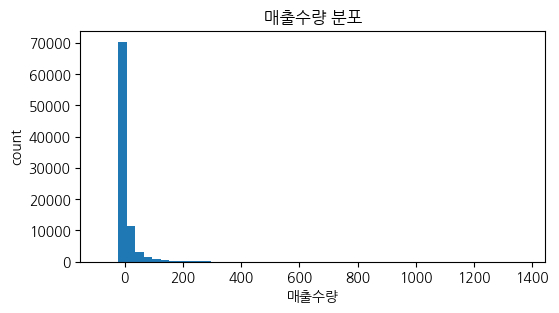

0 매출 비율: 50.55%


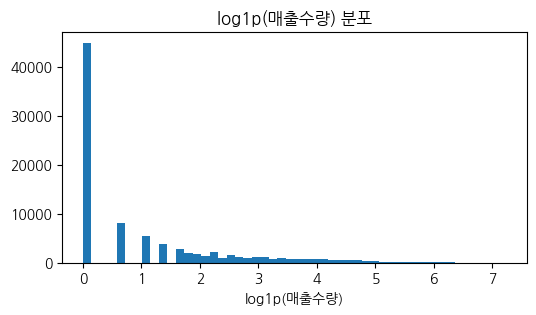

In [14]:
#2) 타깃 분포와 0비율
target = '매출수량'   # or '매출액'
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(df[target].dropna(), bins=50)
ax.set_title(f"{target} 분포"); ax.set_xlabel(target); ax.set_ylabel("count")
plt.show()

zero_rate = (df[target]==0).mean()
print(f"0 매출 비율: {zero_rate:.2%}")

# 로그 변환 분포(0 포함 위해 log1p)
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(np.log1p(df[target].clip(lower=0)), bins=50)
ax.set_title(f"log1p({target}) 분포"); ax.set_xlabel(f"log1p({target})")
plt.show()

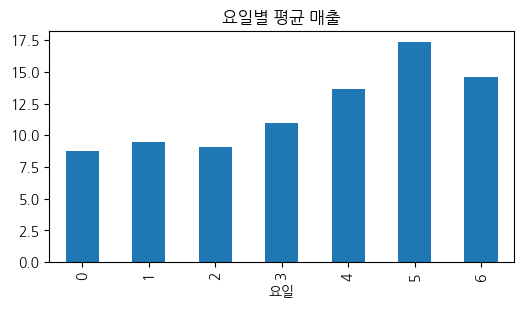

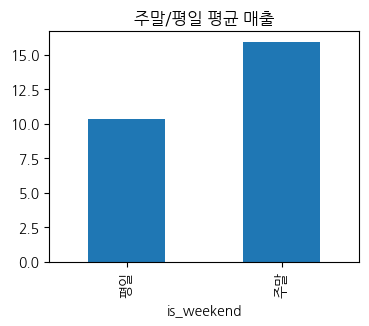

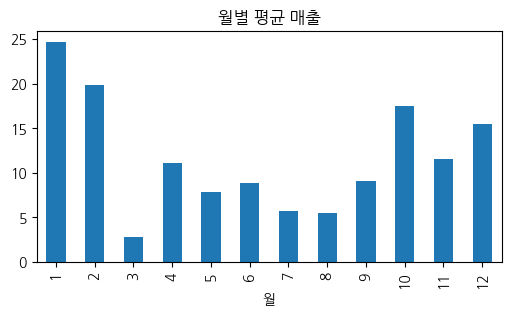

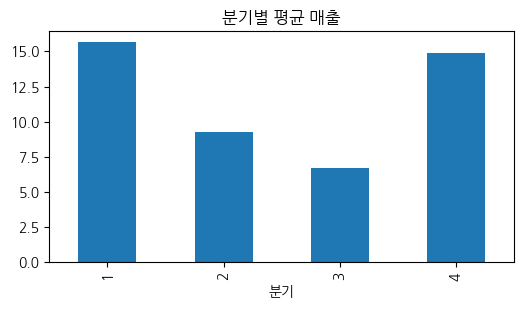

In [15]:
#3) 캘린더 패턴(요일/주말/월/분기)
# 요일별 평균
if '요일' in df.columns:
    s = df.groupby('요일')[target].mean()
    s.plot(kind='bar', figsize=(6,3), title="요일별 평균 매출"); plt.show()

# 주말 vs 평일
if 'is_weekend' in df.columns:
    s = df.groupby('is_weekend')[target].mean().rename(index={0:'평일',1:'주말'})
    s.plot(kind='bar', figsize=(4,3), title="주말/평일 평균 매출"); plt.show()

# 월/분기
for col in ['월','분기']:
    if col in df.columns:
        s = df.groupby(col)[target].mean()
        s.plot(kind='bar', figsize=(6,3), title=f"{col}별 평균 매출"); plt.show()

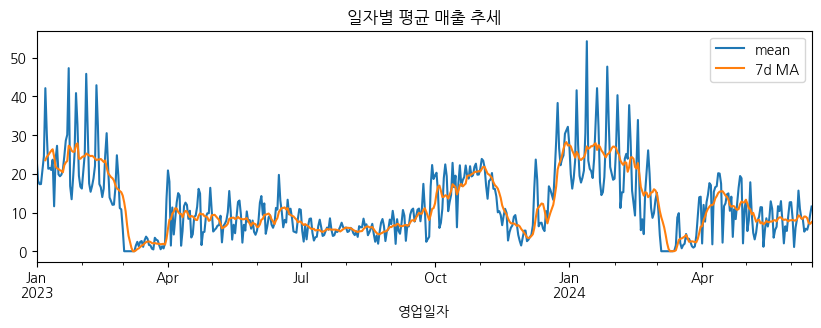

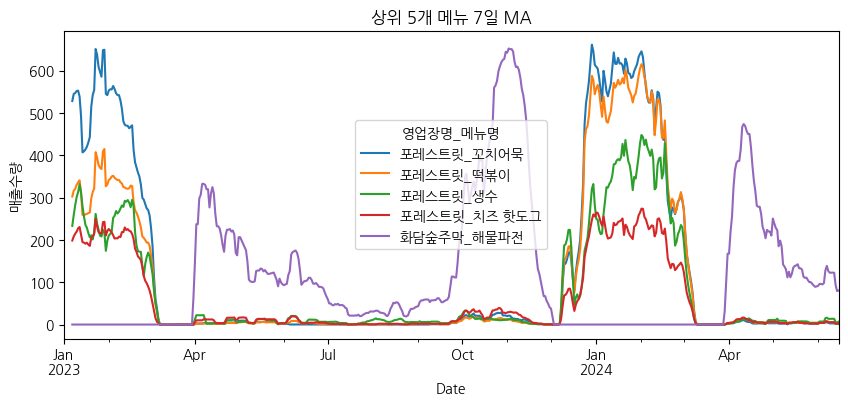

In [16]:
#4) 시계열 추세(전체/메뉴별)
# 전체 일자 평균 추세 + 7일 이동평균
daily = df.groupby('영업일자')[target].mean().sort_index()
fig, ax = plt.subplots(figsize=(10,3))
daily.plot(ax=ax, label='mean')
daily.rolling(7).mean().plot(ax=ax, label='7d MA')
ax.set_title("일자별 평균 매출 추세"); ax.legend(); plt.show()

# 메뉴 상위 5개만 비교
if '영업장명_메뉴명' in df.columns:
    top5 = df.groupby('영업장명_메뉴명')[target].sum().nlargest(5).index
    pivot = (df[df['영업장명_메뉴명'].isin(top5)]
             .pivot_table(index='영업일자', columns='영업장명_메뉴명', values=target, aggfunc='mean'))
    pivot = pivot.sort_index().rolling(7).mean()
    pivot.plot(figsize=(10,4), title="상위 5개 메뉴 7일 MA")
    plt.xlabel("Date"); plt.ylabel(target); plt.show()


매출액                  0.727503
ski_peak             0.166531
ski_total            0.166388
ski_total_lag1       0.148031
ski_peak_lag1        0.147578
ski_total_7dmean     0.141229
ski_peak_7dmean      0.138241
ski_total_lag7       0.133876
ski_peak_lag7        0.133756
ski_total_14dmean    0.133739
ski_peak_14dmean     0.127227
is_ski_season        0.125840
ski_peak_hour        0.111601
요일                   0.060535
is_weekend           0.056568
Name: 매출수량, dtype: float64

분기                 -0.023960
강수량(mm)_lag1       -0.024761
강수량(mm)            -0.030757
month              -0.040871
월                  -0.040871
강수량(mm)_7dmean     -0.043662
강수량(mm)_14dmean    -0.048983
최저기온(℃)            -0.091752
최고기온(℃)            -0.095967
평균기온(℃)            -0.097062
평균기온(℃)_lag7       -0.097153
평균기온(℃)_lag1       -0.098984
평균기온(℃)_14dmean    -0.100440
평균기온(℃)_7dmean     -0.102769
is_hwadam_season   -0.125840
Name: 매출수량, dtype: float64

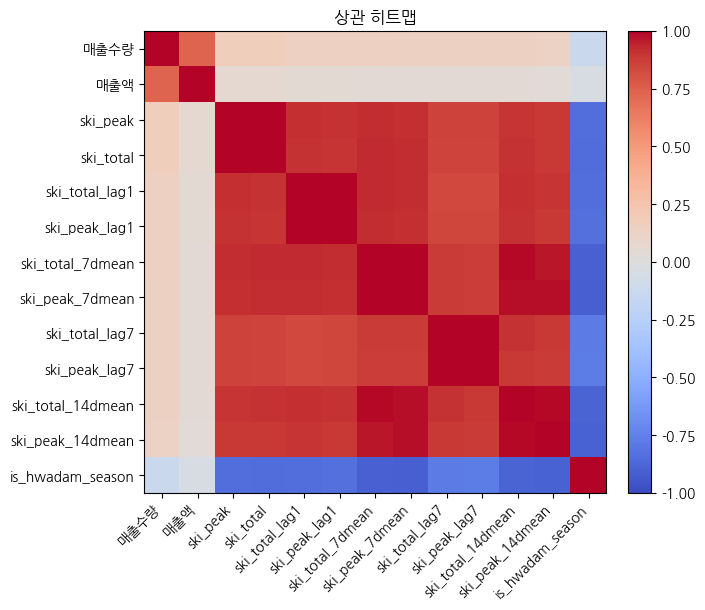

In [17]:
#5) 외부 변수와 상관관계(숫자열만)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()

# 타깃과의 상관 top-k
k = 15
tc = corr[target].drop(labels=[target]).sort_values(ascending=False)
display(tc.head(k))
display(tc.tail(k))

# 간단 히트맵(상위 상관 변수만)
top_vars = tc.abs().sort_values(ascending=False).head(12).index.tolist()
subcorr = df[[target] + top_vars].corr()
fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(subcorr, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(subcorr.columns))); ax.set_yticks(range(len(subcorr.index)))
ax.set_xticklabels(subcorr.columns, rotation=45, ha='right'); ax.set_yticklabels(subcorr.index)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04); ax.set_title("상관 히트맵")
plt.show()

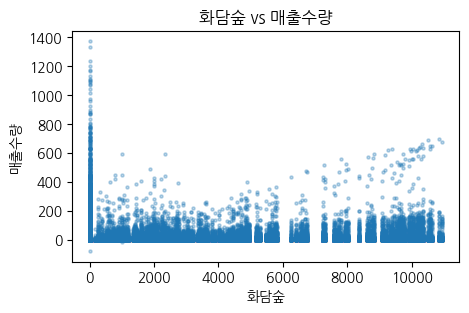

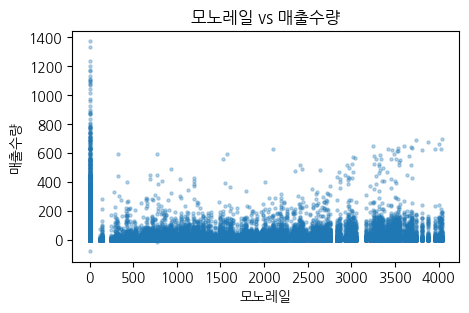

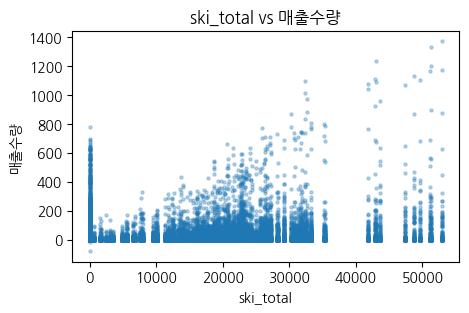

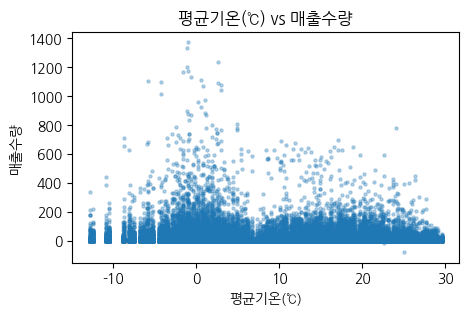

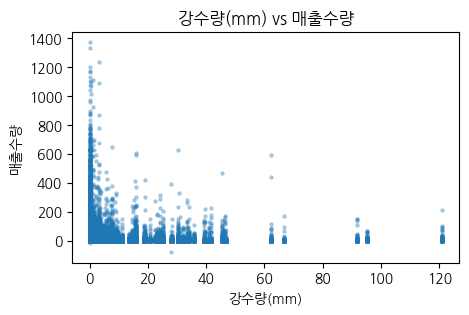

/tmp/ipykernel_383021/2817221907.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s = df.groupby(temp_bin)[target].mean()


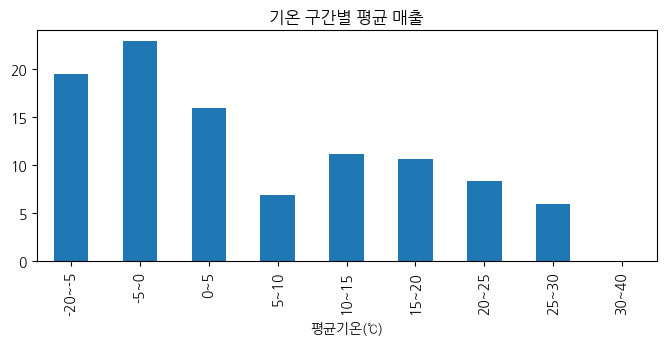

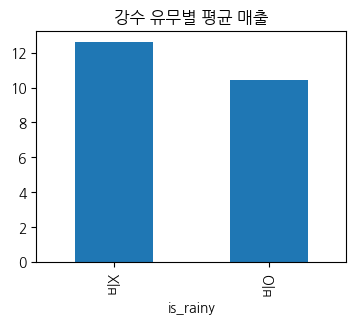

In [18]:
#6) 외부 변수 ↔ 매출 관계 시각화(산점도/바이닝)
cands = [c for c in ['화담숲','모노레일','ski_total','평균기온(℃)','강수량(mm)'] if c in df.columns]
for c in cands:
    fig, ax = plt.subplots(figsize=(5,3))
    ax.scatter(df[c], df[target], s=5, alpha=0.3)
    ax.set_title(f"{c} vs {target}"); ax.set_xlabel(c); ax.set_ylabel(target)
    plt.show()

# 기온을 구간화하여 평균 매출 비교
if '평균기온(℃)' in df.columns:
    bins = [-20,-5,0,5,10,15,20,25,30,40]
    labels = [f"{bins[i]}~{bins[i+1]}" for i in range(len(bins)-1)]
    temp_bin = pd.cut(df['평균기온(℃)'], bins=bins, labels=labels, include_lowest=True)
    s = df.groupby(temp_bin)[target].mean()
    s.plot(kind='bar', figsize=(8,3), title="기온 구간별 평균 매출"); plt.show()

# 비/눈 플래그가 있으면
if 'is_rainy' in df.columns:
    s = df.groupby('is_rainy')[target].mean().rename(index={0:'비X',1:'비O'})
    s.plot(kind='bar', figsize=(4,3), title="강수 유무별 평균 매출"); plt.show()


In [19]:
#7) lag/rolling 자체진단(자기상관/지연효과)
# 매출 lag1, lag7을 직접 만들어 상관 체크(이미 있으면 건너뛰기)
if '매출수량_lag1' not in df.columns:
    df = df.sort_values('영업일자').copy()
    df['매출수량_lag1'] = df.groupby('영업장명_메뉴명')[target].shift(1)
    df['매출수량_lag7'] = df.groupby('영업장명_메뉴명')[target].shift(7)

print("corr(target, lag1):", df[[target,'매출수량_lag1']].corr().iloc[0,1])
print("corr(target, lag7):", df[[target,'매출수량_lag7']].corr().iloc[0,1])


corr(target, lag1): 0.7935352669047825
corr(target, lag7): 0.7906350663179131


In [20]:
#8) 기본 전처리 체크(이상치/결측/스케일)
# 이상치 후보: IQR로 단순 탐지
q1, q3 = df[target].quantile([0.25, 0.75])
iqr = q3 - q1
high_thr = q3 + 1.5*iqr
low_thr  = max(0, q1 - 1.5*iqr)
print("이상치 경계:", low_thr, high_thr)
outliers = df[(df[target] < low_thr) | (df[target] > high_thr)]
print("이상치 건수:", len(outliers))

# 결측 분포(상위)
na_cols = df.columns[df.isna().any()].tolist()
if na_cols:
    na_pct = (df[na_cols].isna().mean()*100).sort_values(ascending=False)
    print("결측 비율 상위:")
    display(na_pct.head(20))

이상치 경계: 0 12.5
이상치 건수: 14021
결측 비율 상위:


매출액          4.191617
매출수량_lag7    1.315789
매출수량_lag1    0.187970
dtype: float64

In [21]:
#9) 모델용 파생변수 초안(필요시)
# 증감률/차분
for col in ['화담숲','모노레일','ski_total']:
    if col in df.columns:
        df[f'{col}_pctchg1'] = df[col].pct_change().fillna(0)
        df[f'{col}_diff1']   = df[col].diff().fillna(0)

# 상호작용 예: 주말 * 방문객, 비 * 스키
if 'is_weekend' in df.columns and '화담숲' in df.columns:
    df['wknd_hwadam'] = df['is_weekend'] * df['화담숲']
if 'is_rainy' in df.columns and 'ski_total' in df.columns:
    df['rain_ski'] = df['is_rainy'] * df['ski_total']

display(df.head(3))

,영업일자,영업장명_메뉴명,매출수량,매출액,화담숲,화담채,모노레일,ski_total,ski_peak,ski_peak_hour,...,매출수량_lag1,매출수량_lag7,화담숲_pctchg1,화담숲_diff1,모노레일_pctchg1,모노레일_diff1,ski_total_pctchg1,ski_total_diff1,wknd_hwadam,rain_ski
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,0.0,0.0,0.0,0.0,20777.0,1970.0,14,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72884,2023-01-01,카페테리아_짬뽕밥,24,360000.0,0.0,0.0,0.0,20777.0,1970.0,14,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40432,2023-01-01,라그로타_아메리카노,3,15000.0,0.0,0.0,0.0,20777.0,1970.0,14,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df

,영업일자,영업장명_메뉴명,매출수량,매출액,화담숲,화담채,모노레일,ski_total,ski_peak,ski_peak_hour,...,매출수량_lag1,매출수량_lag7,화담숲_pctchg1,화담숲_diff1,모노레일_pctchg1,모노레일_diff1,ski_total_pctchg1,ski_total_diff1,wknd_hwadam,rain_ski
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,0.0,0.0,0.0,0.0,20777.0,1970.0,14,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72884,2023-01-01,카페테리아_짬뽕밥,24,360000.0,0.0,0.0,0.0,20777.0,1970.0,14,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40432,2023-01-01,라그로타_아메리카노,3,15000.0,0.0,0.0,0.0,20777.0,1970.0,14,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60116,2023-01-01,미라시아_코카콜라,0,0.0,0.0,0.0,0.0,20777.0,1970.0,14,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28728,2023-01-01,담하_카스,3,21000.0,0.0,0.0,0.0,20777.0,1970.0,14,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21279,2024-06-15,담하_더덕 한우 지짐,1,40000.0,3034.0,734.0,1740.0,0.0,0.0,8,...,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3034.0,0.0
67031,2024-06-15,카페테리아_새우튀김 우동,0,0.0,3034.0,734.0,1740.0,0.0,0.0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3034.0,0.0
21811,2024-06-15,담하_들깨 양지탕,0,0.0,3034.0,734.0,1740.0,0.0,0.0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3034.0,0.0
59051,2024-06-15,미라시아_유자 하이볼,0,0.0,3034.0,734.0,1740.0,0.0,0.0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3034.0,0.0


In [23]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable


In [24]:
# 필요 라이브러리
from prophet import Prophet
import pandas as pd, numpy as np

def prophet_predict_next7(df, min_len=60):
    d = df.copy()
    if d["영업일자"].dtype.kind != "M":
        d["영업일자"] = pd.to_datetime(d["영업일자"])
    d = d.sort_values(["영업장명_메뉴명","영업일자"])
    d["매출수량"] = d["매출수량"].fillna(0).clip(lower=0)

    # 너무 짧은 시계열 제외(원하면 줄여도 됨)
    keep = d["영업장명_메뉴명"].value_counts()
    keep = keep[keep >= min_len].index
    d = d[d["영업장명_메뉴명"].isin(keep)]

    def _one(g, H=7):
        tmp = g.rename(columns={"영업일자":"ds","매출수량":"y"})[["ds","y"]].copy()
        tmp["y"] = np.log1p(tmp["y"].astype(float))
        m = Prophet(yearly_seasonality=True, weekly_seasonality=True,
                    daily_seasonality=False, changepoint_prior_scale=0.3)
        m.fit(tmp)
        future = m.make_future_dataframe(periods=H, freq="D", include_history=False)
        yhat = m.predict(future)[["ds","yhat"]]
        yhat["매출수량"] = np.expm1(yhat["yhat"]).clip(lower=0)
        yhat["영업장명_메뉴명"] = g["영업장명_메뉴명"].iloc[0]
        return yhat.rename(columns={"ds":"영업일자"})[["영업일자","영업장명_메뉴명","매출수량"]]

    preds = [ _one(g) for _, g in d.groupby("영업장명_메뉴명", sort=False) ]
    return pd.concat(preds, ignore_index=True)

# 사용:
prophet_pred = prophet_predict_next7(df)
prophet_pred.head()

/opt/miniconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
04:11:00 - cmdstanpy - INFO - Chain [1] start processing
04:11:00 - cmdstanpy - INFO - Chain [1] done processing
04:11:00 - cmdstanpy - INFO - Chain [1] start processing
04:11:00 - cmdstanpy - INFO - Chain [1] done processing
04:11:00 - cmdstanpy - INFO - Chain [1] start processing
04:11:00 - cmdstanpy - INFO - Chain [1] done processing
04:11:00 - cmdstanpy - INFO - Chain [1] start processing
04:11:01 - cmdstanpy - INFO - Chain [1] done processing
04:11:01 - cmdstanpy - INFO - Chain [1] start processing
04:11:01 - cmdstanpy - INFO - Chain [1] done processing
04:11:01 - cmdstanpy - INFO - Chain [1] start processing
04:11:01 - cmdstanpy - INFO - Chain [1] done processing
04:11:01 - cmdstanpy - INFO - Chain [1] start processing
04:11:01 - cmdst

,영업일자,영업장명_메뉴명,매출수량
0,2024-06-16,느티나무 셀프BBQ_1인 수저세트,3.461663
1,2024-06-17,느티나무 셀프BBQ_1인 수저세트,1.036382
2,2024-06-18,느티나무 셀프BBQ_1인 수저세트,1.531606
3,2024-06-19,느티나무 셀프BBQ_1인 수저세트,1.521988
4,2024-06-20,느티나무 셀프BBQ_1인 수저세트,2.312195


In [25]:
import pandas as pd, numpy as np, torch, math
from torch import nn
from torch.utils.data import Dataset, DataLoader

WIN_IN, WIN_OUT = 28, 7
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ============== 전처리/윈도우 ==============

def _make_X(df28):
    d = df28.sort_values("영업일자").copy()
    if d["영업일자"].dtype.kind != "M":
        d["영업일자"] = pd.to_datetime(d["영업일자"], errors="coerce")
    d = d.dropna(subset=["영업일자"])

    # 수치 안전화
    y = pd.to_numeric(d["매출수량"], errors="coerce").fillna(0).clip(lower=0).values.astype(float)

    dow = d["영업일자"].dt.dayofweek.values
    mon = d["영업일자"].dt.month.values
    X = np.column_stack([
        y,
        np.sin(2*np.pi*dow/7.0), np.cos(2*np.pi*dow/7.0),
        np.sin(2*np.pi*(mon-1)/12.0), np.cos(2*np.pi*(mon-1)/12.0),
        (dow>=5).astype(float),
    ])
    return X

def _prepare_windows(df):
    d = df.copy()
    if d["영업일자"].dtype.kind != "M":
        d["영업일자"] = pd.to_datetime(d["영업일자"], errors="coerce")
    d = d.dropna(subset=["영업일자"])
    d = d.sort_values(["영업장명_메뉴명","영업일자"]).reset_index(drop=True)

    # 타깃 안전화
    d["매출수량"] = pd.to_numeric(d["매출수량"], errors="coerce").fillna(0).clip(lower=0)

    Xs, Ys = [], []
    for _, g in d.groupby("영업장명_메뉴명", sort=False):
        g = g[["영업일자","매출수량"]].reset_index(drop=True)
        if len(g) < WIN_IN + WIN_OUT:
            continue
        for s in range(0, len(g) - (WIN_IN + WIN_OUT) + 1):
            win = g.iloc[s:s+WIN_IN]
            trg = g.iloc[s+WIN_IN:s+WIN_IN+WIN_OUT]["매출수량"].values.astype(float)
            Xs.append(_make_X(win))              # (28, F)
            Ys.append(np.log1p(trg))             # 안정화 (log1p)

    if not Xs:
        raise ValueError("학습 가능한 윈도우가 없습니다. (각 시계열 길이 < 35)")

    X = np.stack(Xs); Y = np.stack(Ys)
    # 정규화 통계 (훈련 통계 고정)
    F = X.shape[2]
    flat = X.reshape(-1, F)
    mu = np.nanmean(flat, axis=0)
    sd = np.nanstd(flat, axis=0) + 1e-6
    X = (X - mu) / sd
    return X, Y, mu, sd

class SeqDS(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i]

# ============== 모델 ==============

class LSTM7(nn.Module):
    """입력: (B, 28, F) -> 출력: (B, 7)  — 기존과 동일"""
    def __init__(self, in_dim, hid=256, layers=2, dropout=0.15):
        super().__init__()
        # cuDNN의 LSTM은 dropout 파라미터가 layers>1일 때만 적용
        self.lstm = nn.LSTM(in_dim, hid, num_layers=layers, batch_first=True, dropout=(dropout if layers>1 else 0.0))
        self.head = nn.Sequential(
            nn.LayerNorm(hid),
            nn.Linear(hid, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, WIN_OUT)
        )
    def forward(self, x):
        out,_ = self.lstm(x)           # (B,T,H)
        return self.head(out[:,-1])    # (B,7)

# ============== 학습 루프(안정화) ==============

def _smape_like_loss(pred, target, eps=1.0):
    # pred/target는 log1p(y) 공간. 실수 공간 복원 후 SMAPE 유사 손실.
    yp = torch.expm1(pred).clamp_min(0)
    yt = torch.expm1(target).clamp_min(0)
    denom = (yp.abs() + yt.abs()).clamp_min(eps)
    return (2.0 * (yp - yt).abs() / denom).mean()

def train_lstm_global(df, epochs=40, batch=512, lr=1e-3, loss_type="huber", patience=10):
    """
    반환/출력 동일:
      -> (model, mu, sd)
    개선점:
      - EarlyStopping(patience)
      - Huber/SMAPE/MSE 선택 (기본 Huber로 이상치에 안정적)
      - CPU/GPU 모두 AMP 안전
      - pin_memory/non_blocking로 I/O 개선
    """
    X, Y, mu, sd = _prepare_windows(df)
    N, T, F = X.shape
    split = max(int(N*0.9), 1)

    dl_tr = DataLoader(SeqDS(X[:split], Y[:split]), batch_size=batch, shuffle=True,
                       pin_memory=torch.cuda.is_available(), drop_last=False)
    dl_va = DataLoader(SeqDS(X[split:], Y[split:]), batch_size=batch, shuffle=False,
                       pin_memory=torch.cuda.is_available(), drop_last=False)

    model = LSTM7(F).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # plateaus에서 LR 감소 + 코사인은 충돌하므로 단일 스케줄 사용
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5, verbose=False)

    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    def _loss_fn(p, y):
        if loss_type == "mse":   return nn.functional.mse_loss(p, y)
        if loss_type == "smape": return _smape_like_loss(p, y)
        return nn.functional.huber_loss(p, y, delta=1.0)  # default=huber

    best = {"va": float("inf"), "state": None, "ep": -1}
    bad = 0

    for ep in range(1, epochs+1):
        model.train(); tr=0.0
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=use_amp):
                pred = model(xb)
                loss = _loss_fn(pred, yb)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt); scaler.update()
            tr += loss.item()*len(xb)
        tr /= max(len(dl_tr.dataset), 1)

        model.eval(); va=0.0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
                pred = model(xb)
                va += _loss_fn(pred, yb).item()*len(xb)
        va /= max(len(dl_va.dataset), 1)
        sched.step(va)

        if (ep % 5 == 0) or (ep == 1):
            print(f"[LSTM] ep {ep:02d} | train {tr:.4f} | valid {va:.4f} | lr {opt.param_groups[0]['lr']:.2e}")

        # EarlyStopping
        if va < best["va"] - 1e-6:
            best = {"va": va,
                    "state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
                    "ep": ep}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                # print(f"[EarlyStop] best@{best['ep']} valid={best['va']:.4f}")
                break

    if best["state"] is not None:
        model.load_state_dict(best["state"])
    return model, mu, sd

# ============== 예측 ==============

def predict_next7_each_id(df, model, mu, sd):
    d = df.copy()
    if d["영업일자"].dtype.kind != "M":
        d["영업일자"] = pd.to_datetime(d["영업일자"], errors="coerce")
    d = d.dropna(subset=["영업일자"])
    d = d.sort_values(["영업장명_메뉴명","영업일자"]).reset_index(drop=True)

    # 안전화
    if "매출수량" in d.columns:
        d["매출수량"] = pd.to_numeric(d["매출수량"], errors="coerce").fillna(0).clip(lower=0)

    out = []
    with torch.no_grad():
        for gid, g in d.groupby("영업장명_메뉴명", sort=False):
            if len(g) < WIN_IN:
                continue
            x = _make_X(g.tail(WIN_IN))
            x = ((x - mu) / sd)[None, :, :]
            yhat = model(torch.tensor(x, dtype=torch.float32, device=DEVICE)).cpu().numpy().ravel()
            yhat = np.expm1(yhat).clip(0)

            last_date = g["영업일자"].iloc[-1]
            future = pd.date_range(last_date + pd.Timedelta(days=1), periods=WIN_OUT, freq="D")
            out += [{"영업일자": dt, "영업장명_메뉴명": gid, "매출수량": float(v)} for dt, v in zip(future, yhat)]
    return pd.DataFrame(out)


In [30]:
# ===== 사용 예시(출력 동일) =====
model, mu, sd = train_lstm_global(df, epochs=40)               # (반환 동일)
lstm_pred = predict_next7_each_id(df, model, mu, sd)           # (컬럼/형태 동일)
lstm_pred.head()

/home/ubuntu/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_383021/2410803195.py:122: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_383021/2410803195.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[LSTM] ep 01 | train 0.3900 | valid 0.4291 | lr 1.00e-03
[LSTM] ep 05 | train 0.2916 | valid 0.4208 | lr 1.00e-03
[LSTM] ep 10 | train 0.2629 | valid 0.4036 | lr 1.00e-03
[LSTM] ep 15 | train 0.2493 | valid 0.3985 | lr 1.00e-03
[LSTM] ep 20 | train 0.2401 | valid 0.4043 | lr 1.00e-03
[LSTM] ep 25 | train 0.2346 | valid 0.4023 | lr 1.00e-03
[LSTM] ep 30 | train 0.2251 | valid 0.4058 | lr 5.00e-04
[LSTM] ep 35 | train 0.2098 | valid 0.3790 | lr 5.00e-04
[LSTM] ep 40 | train 0.1980 | valid 0.3822 | lr 2.50e-04


,영업일자,영업장명_메뉴명,매출수량
0,2024-06-16,느티나무 셀프BBQ_1인 수저세트,1.870692
1,2024-06-17,느티나무 셀프BBQ_1인 수저세트,0.463775
2,2024-06-18,느티나무 셀프BBQ_1인 수저세트,1.045871
3,2024-06-19,느티나무 셀프BBQ_1인 수저세트,1.264638
4,2024-06-20,느티나무 셀프BBQ_1인 수저세트,1.859123


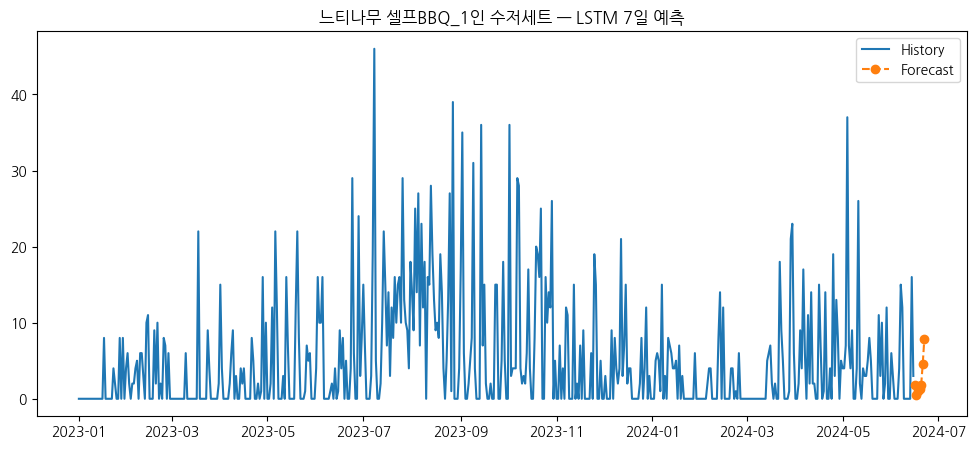

In [31]:
import matplotlib.pyplot as plt
gid = lstm_pred["영업장명_메뉴명"].unique()[0]
hist = df[df["영업장명_메뉴명"]==gid].sort_values("영업일자")
future = lstm_pred[lstm_pred["영업장명_메뉴명"]==gid]

plt.figure(figsize=(12,5))
plt.plot(hist["영업일자"], hist["매출수량"], label="History")
plt.plot(future["영업일자"], future["매출수량"], "o--", label="Forecast")
plt.title(f"{gid} — LSTM 7일 예측")
plt.legend(); plt.show()

In [33]:
def backtest(df, model, mu, sd, H=7):
    """
    df: 전체 데이터프레임 (영업일자, 영업장명_메뉴명, 매출수량)
    model, mu, sd: 학습된 모델과 스케일링 통계
    H: 예측 지평 (기본 7일)

    반환: 전체 그룹/윈도우에 대한 평균 RMSE
    """
    df = df.copy()
    if df["영업일자"].dtype.kind != "M":
        df["영업일자"] = pd.to_datetime(df["영업일자"], errors="coerce")
    df = df.dropna(subset=["영업일자"])
    df = df.sort_values(["영업장명_메뉴명","영업일자"]).reset_index(drop=True)

    rmses = []
    for gid, g in df.groupby("영업장명_메뉴명", sort=False):
        g = g.sort_values("영업일자").reset_index(drop=True)
        if len(g) < WIN_IN + H:
            continue

        # 슬라이딩 윈도우로 백테스트
        for s in range(0, len(g) - (WIN_IN + H) + 1):
            hist = g.iloc[s:s+WIN_IN]
            true = g.iloc[s+WIN_IN:s+WIN_IN+H]["매출수량"].values.astype(float)

            x = _make_X(hist)
            x = ((x - mu) / sd)[None, :, :]
            with torch.no_grad():
                pred = model(torch.tensor(x, dtype=torch.float32, device=DEVICE)).cpu().numpy().ravel()
            pred = np.expm1(pred).clip(0)

            rmse = math.sqrt(mean_squared_error(true, pred))
            rmses.append(rmse)

    return float(np.mean(rmses)) if rmses else None

In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = backtest(df, model, mu, sd, H=7)  # backtest 함수 정의 필요
print("백테스트 평균 RMSE:", rmse)

백테스트 평균 RMSE: 8.077418439665005


(1169, 3)
        영업일자              영업장명_메뉴명       매출수량
0 2024-06-16    느티나무 셀프BBQ_1인 수저세트   1.870692
1 2024-06-17    느티나무 셀프BBQ_1인 수저세트   0.463775
2 2024-06-18    느티나무 셀프BBQ_1인 수저세트   1.045871
3 2024-06-19    느티나무 셀프BBQ_1인 수저세트   1.264638
4 2024-06-20    느티나무 셀프BBQ_1인 수저세트   1.859123
5 2024-06-21    느티나무 셀프BBQ_1인 수저세트   4.612148
6 2024-06-22    느티나무 셀프BBQ_1인 수저세트   7.850929
7 2024-06-16  느티나무 셀프BBQ_BBQ55(단체)   0.827316
8 2024-06-17  느티나무 셀프BBQ_BBQ55(단체)   7.359866
9 2024-06-18  느티나무 셀프BBQ_BBQ55(단체)  38.235134


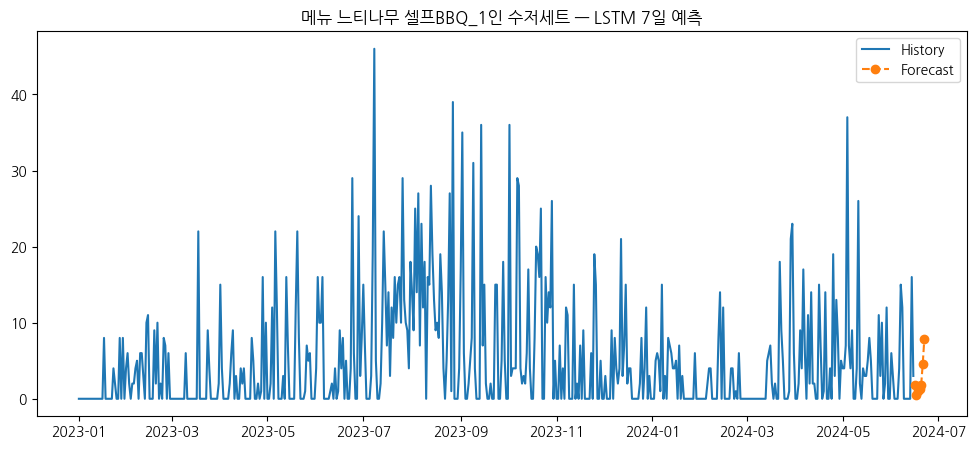

In [36]:
print(lstm_pred.shape)
print(lstm_pred.head(10))

# 특정 메뉴만 뽑아서 그래프 비교
gid = lstm_pred["영업장명_메뉴명"].unique()[0]
hist = df[df["영업장명_메뉴명"]==gid].sort_values("영업일자")
future = lstm_pred[lstm_pred["영업장명_메뉴명"]==gid]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(hist["영업일자"], hist["매출수량"], label="History")
plt.plot(future["영업일자"], future["매출수량"], "o--", label="Forecast")
plt.title(f"메뉴 {gid} — LSTM 7일 예측")
plt.legend()
plt.show()

In [37]:
# from sklearn.metrics import mean_squared_error
# import numpy as np

# def backtest(df, model, mu, sd, H=7):
#     rmses = []
#     for gid, g in df.groupby("영업장명_메뉴명"):
#         g = g.sort_values("영업일자").reset_index(drop=True)
#         if len(g) < WIN_IN+WIN_OUT: continue
#         for s in range(0, len(g)-(WIN_IN+H)+1, H):  # H일 단위 롤링
#             x = _make_X(g.iloc[s:s+WIN_IN])
#             y_true = g.iloc[s+WIN_IN:s+WIN_IN+H]["매출수량"].values
#             x = ((x - mu)/sd)[None,:,:]
#             with torch.no_grad():
#                 y_pred = np.expm1(model(torch.tensor(x, dtype=torch.float32, device=DEVICE)).cpu().numpy().ravel())
#             rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#             rmses.append(rmse)
#     return np.mean(rmses)

# rmse = backtest(df, model, mu, sd)
# print("백테스트 평균 RMSE:", rmse)

In [38]:
# ====== LG Aimers F&B 제출 생성 (LSTM 전역모델 활용, 28→7) ======
import os, glob, re
import numpy as np
import pandas as pd
import torch

WIN_IN, WIN_OUT = 28, 7
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 0) BASE 및 샘플 파일 자동 탐지
def _has_dataset(root):
    return os.path.exists(os.path.join(root, "train.csv")) and \
           os.path.exists(os.path.join(root, "price.csv"))

def resolve_base():
    for c in ["/data/train", "/mnt/data", os.getcwd()]:
        if _has_dataset(c):
            return c
    # CWD 주변 얕은 탐색
    cwd = os.path.abspath(os.getcwd())
    cand = {cwd}
    p = cwd
    for _ in range(3):
        p = os.path.dirname(p); cand.add(p)
    for up in list(cand):
        for sub in ["", "data", "data/train", "train"]:
            c = os.path.abspath(os.path.join(up, sub))
            if _has_dataset(c): return c
    raise FileNotFoundError("데이터 루트를 찾지 못했어요. train.csv/price.csv가 있는 폴더를 확인하세요.")

BASE = resolve_base()
print("[BASE]", BASE)

# sample_submission 자동탐지 (두 가지 파일명 모두 대응)
SAMPLE = None
for cand in ["sample_submission.csv", "sample_submission.csv.csv"]:
    p = os.path.join(BASE, cand)
    if os.path.exists(p):
        SAMPLE = p; break
assert SAMPLE is not None, "sample_submission 파일을 찾을 수 없어요."
sample = pd.read_csv(SAMPLE)
is_long = list(sample.columns) == ["영업일자","영업장명_메뉴명","매출수량"]
print("[SAMPLE]", SAMPLE, "| long_format:", is_long)

# --- 1) 도우미: TEST CSV 읽기 (wide/long 모두 허용)
def ensure_long(df):
    """wide -> long으로 변환. 이미 long이면 그대로 반환."""
    if {"영업일자","영업장명_메뉴명","매출수량"}.issubset(df.columns):
        d = df.copy()
        if d["영업일자"].dtype.kind != "M":
            d["영업일자"] = pd.to_datetime(d["영업일자"])
        return d
    # wide -> long
    if "영업일자" not in df.columns:
        # 첫 열이 날짜로 가정
        df = df.rename(columns={df.columns[0]: "영업일자"})
    if df["영업일자"].dtype.kind != "M":
        df["영업일자"] = pd.to_datetime(df["영업일자"])
    dlong = df.melt(id_vars=["영업일자"], var_name="영업장명_메뉴명", value_name="매출수량")
    return dlong

# --- 2) 피처 함수 (학습 때 쓰던 것과 동일)
def _make_X(df28):
    d = df28.sort_values("영업일자").copy()
    dow = d["영업일자"].dt.dayofweek.values
    mon = d["영업일자"].dt.month.values
    X = np.column_stack([
        d["매출수량"].values.astype(float),
        np.sin(2*np.pi*dow/7.0), np.cos(2*np.pi*dow/7.0),
        np.sin(2*np.pi*(mon-1)/12.0), np.cos(2*np.pi*(mon-1)/12.0),
        (dow>=5).astype(float),
    ])
    return X  # (28, F)

# --- 3) 단일 시계열(28일) → 7일 예측
@torch.no_grad()
def predict_next7_from_last28(df28, model, mu, sd):
    x = _make_X(df28)
    x = ((x - mu) / sd)[None, :, :]
    yhat = model(torch.tensor(x, dtype=torch.float32, device=DEVICE)).cpu().numpy().ravel()
    yhat = np.expm1(yhat).clip(0)  # 역변환 + 음수 방지
    return yhat  # shape (7,)

# --- 4) TEST_?? 파일 순회 → 예측 long 데이터프레임 생성
def predict_all_tests(model, mu, sd, base=BASE):
    test_dir = os.path.join(base, "test")
    files_raw = sorted(glob.glob(os.path.join(test_dir, "TEST_*.csv")))
    # 메인 테스트만 (TEST_00 ~ TEST_??) — 서브 파일(meta)은 제외
    files = [p for p in files_raw if re.fullmatch(r"TEST_\d{2}\.csv", os.path.basename(p))]
    assert len(files) > 0, f"{test_dir} 에 TEST_??.csv를 찾지 못했어요."

    outs = []
    for path in files:
        tag = os.path.splitext(os.path.basename(path))[0]  # TEST_00
        try:
            d = pd.read_csv(path, parse_dates=["영업일자"])
        except Exception:
            d = pd.read_csv(path)
        d = ensure_long(d)
        # 안전 보정
        d = d.sort_values(["영업장명_메뉴명","영업일자"]).copy()
        d["매출수량"] = d["매출수량"].fillna(0).clip(lower=0)

        for gid, g in d.groupby("영업장명_메뉴명", sort=False):
            g = g.sort_values("영업일자").reset_index(drop=True)
            assert len(g) == 28, f"{tag}:{gid} 길이가 {len(g)} (28 필요)"
            yhat7 = predict_next7_from_last28(g, model, mu, sd)
            for k in range(1, WIN_OUT+1):
                outs.append({
                    "영업일자": f"{tag}+{k}일",
                    "영업장명_메뉴명": gid,
                    "매출수량": float(yhat7[k-1])
                })
    return pd.DataFrame(outs)

pred_long = predict_all_tests(model, mu, sd, BASE)
print("[PRED]", pred_long.shape, pred_long.head())

# --- 5) sample_submission과 '완전 동일' 포맷 맞춰 저장
if is_long:
    out_df = sample[["영업일자","영업장명_메뉴명"]].merge(
        pred_long, on=["영업일자","영업장명_메뉴명"], how="left"
    )
    out_df["매출수량"] = out_df["매출수량"].fillna(0.0).clip(lower=0.0)
else:
    # wide 샘플: 인덱스(영업일자) 순서를 샘플에 정확히 맞춤
    wide = pred_long.pivot(index="영업일자", columns="영업장명_메뉴명", values="매출수량")
    wide = wide.reindex(index=sample["영업일자"].values)
    out_df = pd.DataFrame({"영업일자": sample["영업일자"]})
    for col in sample.columns[1:]:
        out_df[col] = wide.get(col).fillna(0.0).clip(lower=0.0).values

out_dir = os.path.join(BASE, "submission")
os.makedirs(out_dir, exist_ok=True)
OUT_PATH = os.path.join(out_dir, "submission.csv")
out_df.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")
print("[SAVE]", OUT_PATH)

# --- 6) 최종 검증: 샘플과 완전 동일?
def exact_check(sample_path, pred_path):
    s = pd.read_csv(sample_path)
    p = pd.read_csv(pred_path)
    ok_cols = list(s.columns) == list(p.columns)
    ok_rows = len(s) == len(p)
    ids_equal = False
    if "영업일자" in s.columns and "영업일자" in p.columns:
        ids_equal = s["영업일자"].tolist() == p["영업일자"].tolist()
    neg_ok = (("매출수량" not in p.columns) or (p["매출수량"].min() >= 0))
    return {"ok": bool(ok_cols and ok_rows and ids_equal and neg_ok),
            "cols_equal": ok_cols, "rows_equal": ok_rows,
            "ids_equal": ids_equal, "no_negative": neg_ok}

rep = exact_check(SAMPLE, OUT_PATH)
print("[SUBMISSION EXACT CHECK]", rep)

[BASE] /home/ubuntu/workspace/data/train
[SAMPLE] /home/ubuntu/workspace/data/train/sample_submission.csv | long_format: False
[PRED] (11690, 3)          영업일자            영업장명_메뉴명      매출수량
0  TEST_00+1일  느티나무 셀프BBQ_1인 수저세트  7.033171
1  TEST_00+2일  느티나무 셀프BBQ_1인 수저세트  1.840624
2  TEST_00+3일  느티나무 셀프BBQ_1인 수저세트  2.438569
3  TEST_00+4일  느티나무 셀프BBQ_1인 수저세트  2.914890
4  TEST_00+5일  느티나무 셀프BBQ_1인 수저세트  3.973297
[SAVE] /home/ubuntu/workspace/data/train/submission/submission.csv
[SUBMISSION EXACT CHECK] {'ok': True, 'cols_equal': True, 'rows_equal': True, 'ids_equal': True, 'no_negative': True}


/tmp/ipykernel_383021/3246006672.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out_df[col] = wide.get(col).fillna(0.0).clip(lower=0.0).values
/tmp/ipykernel_383021/3246006672.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out_df[col] = wide.get(col).fillna(0.0).clip(lower=0.0).values
/tmp/ipykernel_383021/3246006672.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

In [39]:
# ===== wide 포맷 제출 파일 생성 =====
import os
import pandas as pd

# 0) 경로와 입력(예측 long) 준비
BASE = "/home/ubuntu/workspace/data"  # 데이터 루트에 맞게 수정 가능
SAMPLE = None
for cand in ["sample_submission.csv", "sample_submission.csv.csv"]:
    p = os.path.join(BASE, cand)
    if os.path.exists(p):
        SAMPLE = p; break
assert SAMPLE is not None, "sample_submission 파일을 찾지 못했습니다."

sample = pd.read_csv(SAMPLE)

# pred_long 은 다음 형태여야 함:
# columns = ["영업일자","영업장명_메뉴명","매출수량"]
# 값 예: 영업일자 = "TEST_00+1일" ... "TEST_59+7일"
# 이미 만들었다면 그대로 사용, 아니면 이전 단계의 predict_all_tests() 결과를 넣어주세요.
assert set(["영업일자","영업장명_메뉴명","매출수량"]).issubset(pred_long.columns)

# 1) long -> wide 피벗
wide = pred_long.pivot(index="영업일자",
                       columns="영업장명_메뉴명",
                       values="매출수량")

# 2) 샘플과 '완전 동일' 정렬 (행/열/순서)
#    - 행: sample 의 '영업일자' 순서
#    - 열: sample 의 열 순서(첫 열 '영업일자' 제외)
wide = wide.reindex(index=sample["영업일자"].values)

out_df = pd.DataFrame({"영업일자": sample["영업일자"]})
for col in sample.columns[1:]:
    out_df[col] = wide.get(col).fillna(0.0).clip(lower=0.0).values

# 3) 저장
out_dir = os.path.join(BASE, "submission")
os.makedirs(out_dir, exist_ok=True)
OUT_PATH = os.path.join(out_dir, "submission.csv")
out_df.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")
print("[SAVE]", OUT_PATH)

# 4) 최종 검증 (샘플과 완전 동일?)
s = pd.read_csv(SAMPLE)
p = pd.read_csv(OUT_PATH)
check = {
    "ok": list(s.columns)==list(p.columns)
          and len(s)==len(p)
          and s["영업일자"].tolist()==p["영업일자"].tolist()
          and (("매출수량" not in p.columns) or (p.select_dtypes("number").min().min() >= 0)),
    "cols_equal": list(s.columns)==list(p.columns),
    "rows_equal": len(s)==len(p),
    "ids_equal": s["영업일자"].tolist()==p["영업일자"].tolist(),
    "no_negative": (p.select_dtypes("number").min().min() >= 0)
}
print("[SUBMISSION EXACT CHECK]", check)

# (선택) 미리보기
display(out_df.head())

[SAVE] /home/ubuntu/workspace/data/submission/submission.csv
[SUBMISSION EXACT CHECK] {'ok': True, 'cols_equal': True, 'rows_equal': True, 'ids_equal': True, 'no_negative': np.True_}


/tmp/ipykernel_383021/240130266.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out_df[col] = wide.get(col).fillna(0.0).clip(lower=0.0).values
/tmp/ipykernel_383021/240130266.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out_df[col] = wide.get(col).fillna(0.0).clip(lower=0.0).values
/tmp/ipykernel_383021/240130266.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

,영업일자,느티나무 셀프BBQ_1인 수저세트,느티나무 셀프BBQ_BBQ55(단체),"느티나무 셀프BBQ_대여료 30,000원","느티나무 셀프BBQ_대여료 60,000원","느티나무 셀프BBQ_대여료 90,000원",느티나무 셀프BBQ_스프라이트 (단체),느티나무 셀프BBQ_신라면,느티나무 셀프BBQ_쌈장,느티나무 셀프BBQ_육개장 사발면,...,화담숲주막_스프라이트,화담숲주막_참살이 막걸리,화담숲주막_찹쌀식혜,화담숲주막_콜라,화담숲주막_해물파전,화담숲카페_메밀미숫가루,화담숲카페_아메리카노 HOT,화담숲카페_아메리카노 ICE,화담숲카페_카페라떼 ICE,화담숲카페_현미뻥스크림
0,TEST_00+1일,7.033171,0.000000,5.144471,2.644484,0.439938,0.000000,0.761319,0.428326,0.139486,...,5.171886,23.672981,18.934067,6.215345,54.699085,25.335514,5.773600,7.349032,9.508543,21.831968
1,TEST_00+2일,1.840624,0.163868,1.243149,0.631919,0.123062,0.047091,0.471840,0.243602,0.078628,...,1.365691,5.661674,4.136926,1.508207,12.896574,3.946844,1.968042,1.693372,3.199379,4.307418
2,TEST_00+3일,2.438569,0.565267,1.726373,1.102622,0.227074,0.210929,0.619915,0.219051,0.147261,...,1.659126,5.560497,3.761677,1.825370,11.719462,4.506409,2.096071,4.602466,3.857043,4.294399
3,TEST_00+4일,2.914890,2.728055,2.082646,1.251556,0.304147,1.017149,0.773080,0.249710,0.251648,...,1.971510,6.481279,4.218657,2.197399,14.944201,5.925969,2.434784,7.072033,4.224971,4.840292
4,TEST_00+5일,3.973297,9.006437,2.840635,1.719703,0.313998,2.288810,1.138875,0.280544,0.221969,...,2.471674,7.884204,4.905163,2.776280,18.163273,8.925012,2.865433,11.607339,5.072352,5.993155
